In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from aequitas.group import Group
import joblib
from pycaret.classification import save_model, create_model
from pycaret.classification import load_model

<a id="3.3"></a>
## <b><span style='color:SteelBlue'>Note:</span></b> 

- You will find paths of my device. Please change it to yours.

Example: <span style='color:red'>/Users/gavesh_aggarwal/Desktop</span>/Mule_Account_Detection/32 Column Dataset/archive/Base.csv

- Run the cells based on your requirements. Check out GitHub Readme for details.

<a id="3.3"></a>
## <b><span style='color:SteelBlue'>Training: </span></b>on base

In [2]:
df = pd.read_csv('/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/archive/base.csv')


In [3]:
# Display the first few rows of the dataset and inspect columns
print("Shape of the dataset:", df.shape)
df.head()

Shape of the dataset: (1000000, 33)


,Account_Number,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,1,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,...,0,1500,0,INTERNET,16.224843,linux,1,1,0,0
1,2,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,...,0,1500,0,INTERNET,3.363854,other,1,1,0,0
2,3,0,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,...,0,200,0,INTERNET,22.730559,windows,0,1,0,0
3,4,0,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,...,0,200,0,INTERNET,15.215816,linux,1,1,0,0
4,5,0,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,...,0,200,0,INTERNET,3.743048,other,0,1,0,0


In [4]:
# Remove unnecessary column 'device_fraud_count'
df = df.drop(['device_fraud_count'], axis=1, errors='ignore')

In [5]:
# Count the number of non-frauds and frauds
fraud_counts = df['fraud_bool'].value_counts()
print("Fraud counts:\n", fraud_counts)

Fraud counts:
 fraud_bool
0    988971
1     11029
Name: count, dtype: int64


In [6]:
# Split data into features and target
X = df.drop(['fraud_bool'], axis=1)
y = df['fraud_bool']

In [7]:
# Drop 'month' column
X = X.drop('month', axis=1, errors='ignore')

In [8]:
# Identify categorical columns
object_cols = X.select_dtypes(include='object').columns

In [9]:
# Initialize OneHotEncoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

In [10]:
# One-hot encode categorical columns
ohe_cols = pd.DataFrame(ohe.fit_transform(X[object_cols]), index=X.index)

In [11]:
# Drop original categorical columns from the dataset
X = pd.concat([X.drop(object_cols, axis=1), ohe_cols], axis=1)

In [12]:
# Ensure all column names are strings
X.columns = X.columns.astype(str)

In [13]:
# Display first row of transformed data
X.head(1)

,Account_Number,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,...,16,17,18,19,20,21,22,23,24,25
0,1,0.3,0.986506,-1,25,40,0.006735,102.453711,1059,13096.03502,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [14]:
# Initialize StandardScaler
scaler = StandardScaler()

# Scale numerical features
X = scaler.fit_transform(X)

# Display scaled data
X[:1]

array([[-1.73204908, -0.90477846,  1.70449737, -0.40227227, -0.69664367,
         0.52478204, -0.18933513,  4.63488549, -0.51094619,  2.46919315,
         2.0829829 ,  2.05008417, -0.39023511, -0.89466278,  0.45937986,
         0.94191209, -0.84586786,  0.352143  , -0.15179689, -0.53570646,
         2.01852014, -0.16092128,  1.08051695,  0.85630687, -0.10130483,
         1.69476601, -0.76726699, -0.58053881, -0.36723808, -0.01700246,
        -1.64534608,  2.49625428, -0.1980899 , -0.16505933, -0.15238087,
        -0.21462131, -0.02128862, -0.45204833, -0.59423555,  1.29889918,
        -0.16390175, -0.45118174, -0.04088753, -0.01587651,  0.08424979,
        -0.08424979,  1.41619294, -0.23851217, -0.72210812, -0.59815074,
        -0.08532657]])

<a id="3.3"></a>
## <b><span style='color:SteelBlue'>Logistic Regression</span></b>

Logistic Regression AUC: 0.8694400111333436


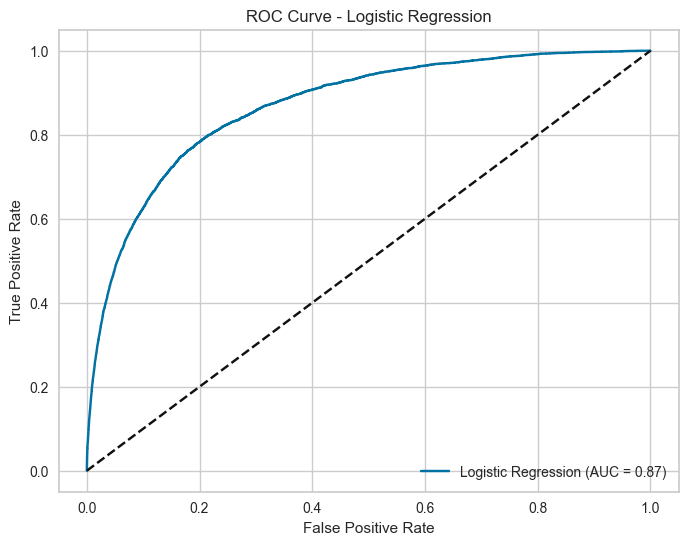

In [15]:
# Train Logistic Regression model
lr_model = LogisticRegression(class_weight='balanced')
lr_model.fit(X, y)

# Predict probabilities for the entire dataset
lr_predictions = lr_model.predict_proba(X)[:, 1]

# Evaluate model performance
lr_auc = roc_auc_score(y, lr_predictions)
print("Logistic Regression AUC:", lr_auc)

# Plot ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y, lr_predictions)
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression (AUC = {:.2f})'.format(lr_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Saving the model
joblib.dump(lr_model, '/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/scripts/baselinemodels-roc/4. MODELS_BASE/lr_model.joblib')

<a id="3.3"></a>
## <b><span style='color:SteelBlue'>XGBoost</span></b>

XGBoost AUC: 0.9811605167064243


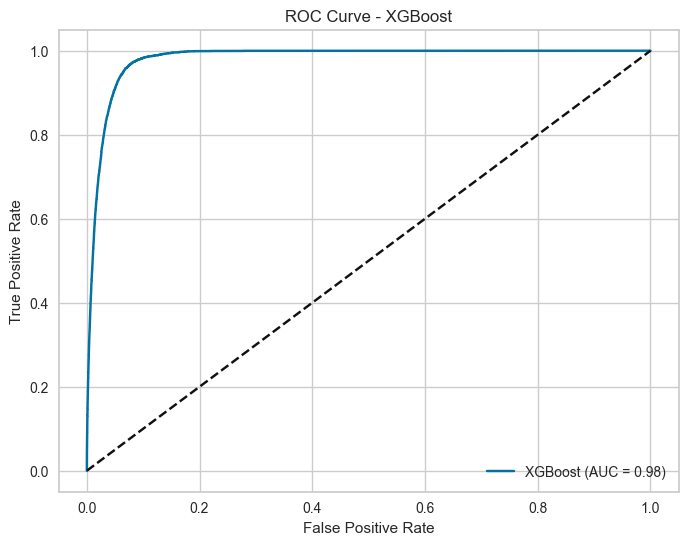

In [16]:
# Train XGBoost model
xgb_model = xgb.XGBClassifier(tree_method='hist', scale_pos_weight=89.67005)
xgb_model.fit(X, y)

# Predict probabilities for the entire dataset
xgb_predictions = xgb_model.predict_proba(X)[:, 1]

# Evaluate model performance
xgb_auc = roc_auc_score(y, xgb_predictions)
print("XGBoost AUC:", xgb_auc)

# Plot ROC curve
fpr_xgb, tpr_xgb, _ = roc_curve(y, xgb_predictions)
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost (AUC = {:.2f})'.format(xgb_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Saving the model
joblib.dump(xgb_model, '/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/scripts/baselinemodels-roc/4. MODELS_BASE/xgb_model.joblib')

<a id="3.3"></a>
## <b><span style='color:SteelBlue'>Random Forest</span></b>

Random Forest AUC: 0.9999999999999999


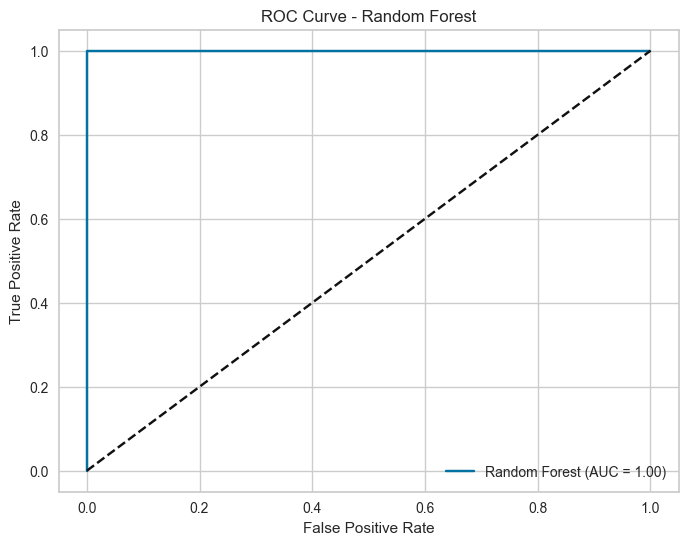

In [17]:
# Train Random Forest model
rf_model = RandomForestClassifier(class_weight='balanced')
rf_model.fit(X, y)

# Predict probabilities for the entire dataset
rf_predictions = rf_model.predict_proba(X)[:, 1]

# Evaluate model performance
rf_auc = roc_auc_score(y, rf_predictions)
print("Random Forest AUC:", rf_auc)

# Plot ROC curve
fpr_rf, tpr_rf, _ = roc_curve(y, rf_predictions)
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = {:.2f})'.format(rf_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Saving the model
joblib.dump(rf_model, '/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/scripts/baselinemodels-roc/4. MODELS_BASE/rf_model.joblib')

<a id="3.3"></a>
## <b><span style='color:SteelBlue'>Note:</span></b> 
After you have trained and saved the models once, you can load them from next time.

In [15]:
# Loading

# BASE
lr_model = joblib.load('/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/scripts/baselinemodels-roc/4. MODELS_BASE/lr_model.joblib')
xgb_model = joblib.load('/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/scripts/baselinemodels-roc/4. MODELS_BASE/xgb_model.joblib')
rf_model = joblib.load('/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/scripts/baselinemodels-roc/4. MODELS_BASE/rf_model.joblib')

<a id="3.3"></a>
## <b><span style='color:SteelBlue'>Testing: </span></b>on variant 1

In [22]:
df2 = pd.read_csv('/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/archive/Variant I new.csv')

In [23]:
# Display the first few rows of the dataset and inspect columns
print("Shape of the dataset:", df2.shape)
df2.head()

Shape of the dataset: (1000000, 33)


,Account_Number,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,1,0,0.9,0.990415,11,4,40,0.014640,-0.897718,AC,...,0,200.0,0,INTERNET,6.150317,windows,0,1,0,0
1,2,0,0.4,0.781728,-1,151,30,0.013269,11.501507,AA,...,0,1500.0,0,INTERNET,4.521952,windows,1,1,0,0
2,3,0,0.7,0.274290,-1,92,20,0.010669,23.943928,AA,...,0,200.0,0,INTERNET,8.361707,other,1,1,0,0
3,4,0,0.9,0.722684,-1,55,20,0.021849,48.202774,AA,...,0,1500.0,0,INTERNET,7.339743,other,0,1,0,0
4,5,0,0.9,0.121661,-1,51,20,0.021491,-1.602116,AB,...,0,1500.0,0,INTERNET,4.338063,other,0,1,0,0


In [24]:
# Remove unnecessary column 'device_fraud_count'
df2 = df2.drop(['device_fraud_count'], axis=1, errors='ignore')

In [25]:
# Count the number of non-frauds and frauds in df2
fraud_counts2 = df2['fraud_bool'].value_counts()
print("Fraud counts in df2:\n", fraud_counts2)

Fraud counts in df2:
 fraud_bool
0    988971
1     11029
Name: count, dtype: int64


In [26]:
# Split data into features and target
X2 = df2.drop(['fraud_bool'], axis=1)
y2 = df2['fraud_bool']

In [28]:
# Drop 'month' column
X2 = X2.drop('month', axis=1, errors='ignore')

In [29]:
# One-hot encode categorical columns
ohe_cols2 = pd.DataFrame(ohe.transform(X2[object_cols]), index=X2.index)

In [30]:
# Drop original categorical columns from the dataset
X2 = pd.concat([X2.drop(object_cols, axis=1), ohe_cols2], axis=1)

# Ensure all column names are strings
X2.columns = X2.columns.astype(str)

# Scale numerical features
X2 = scaler.transform(X2)

# Display transformed data
X2[:1]

array([[-1.73204908,  1.16174673,  1.71801557, -0.12983111, -0.93418262,
         0.52478204, -0.18786645, -0.47238327,  0.27880961,  0.34765524,
         0.06692586,  0.14405054, -0.40111354,  1.88654218, -0.25816785,
         0.94191209, -0.84586786,  0.352143  , -0.97709264, -0.53570646,
        -0.64782023, -0.16092128, -0.17360953, -1.16780564, -0.10130483,
        -0.59005196, -0.76726699,  1.72253773, -0.36723808, -0.01700246,
         0.60777487, -0.40060021, -0.1980899 , -0.16505933, -0.15238087,
        -0.21462131, -0.02128862, -0.45204833, -0.59423555,  1.29889918,
        -0.16390175, -0.45118174, -0.04088753, -0.01587651,  0.08424979,
        -0.08424979, -0.70611848, -0.23851217, -0.72210812,  1.67181937,
        -0.08532657]])

<a id="3.3"></a>
<span style='color:Red'>Making predictions using the trained model.</span>

In [31]:
# Make predictions on df2
lr_predictions2 = lr_model.predict_proba(X2)[:, 1]
xgb_predictions2 = xgb_model.predict_proba(X2)[:, 1]
rf_predictions2 = rf_model.predict_proba(X2)[:, 1]

In [32]:
# Evaluate model performance on df2
lr_auc2 = roc_auc_score(y2, lr_predictions2)
xgb_auc2 = roc_auc_score(y2, xgb_predictions2)
rf_auc2 = roc_auc_score(y2, rf_predictions2)

print("Logistic Regression AUC on df2:", lr_auc2)
print("XGBoost AUC on df2:", xgb_auc2)
print("Random Forest AUC on df2:", rf_auc2)

Logistic Regression AUC on df2: 0.8549554032420941
XGBoost AUC on df2: 0.884770096435018
Random Forest AUC on df2: 0.8391757891822824


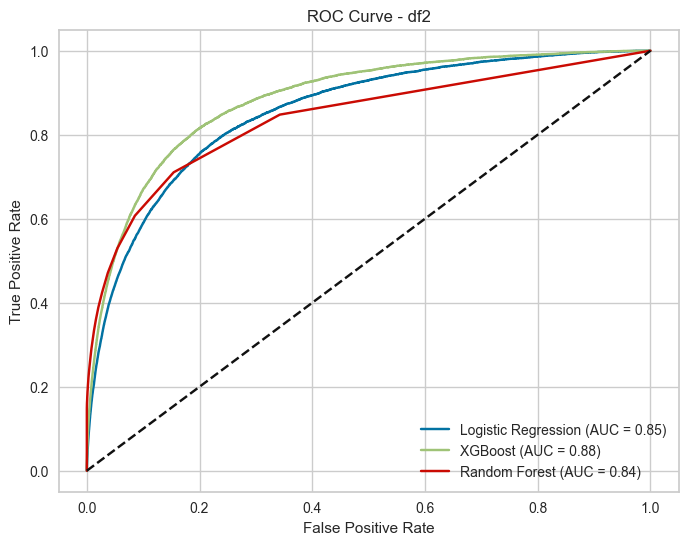

In [33]:
# Plot ROC curves
plt.figure(figsize=(8, 6))
fpr_lr2, tpr_lr2, _ = roc_curve(y2, lr_predictions2)
fpr_xgb2, tpr_xgb2, _ = roc_curve(y2, xgb_predictions2)
fpr_rf2, tpr_rf2, _ = roc_curve(y2, rf_predictions2)

plt.plot(fpr_lr2, tpr_lr2, label='Logistic Regression (AUC = {:.2f})'.format(lr_auc2))
plt.plot(fpr_xgb2, tpr_xgb2, label='XGBoost (AUC = {:.2f})'.format(xgb_auc2))
plt.plot(fpr_rf2, tpr_rf2, label='Random Forest (AUC = {:.2f})'.format(rf_auc2))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - df2')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

<a id="3.3"></a>
## <b><span style='color:SteelBlue'>Validation</span></b>

In [34]:
## Confusion Matrix

## Make binary predictions on df2 using a threshold
# Here, we convert the predicted probabilities into binary class predictions (0 or 1) using a threshold.
# If the probability is greater than or equal to the threshold, it’s classified as 1 (fraud); otherwise, it’s classified as 0 (non-fraud).

## Calculate confusion matrices for each model
# We compute the confusion matrix for each model’s predictions using the true labels y2 and the binary predictions.
# The confusion matrix shows the counts of true positives, true negatives, false positives, and false negatives.

#[[TN      FP]
#[ FN     TP]]

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Function to print evaluation metrics
def print_evaluation_metrics(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f"{model_name} Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}\n")

# Convert probabilities to binary predictions using a threshold
lr_binary_predictions2_80 = (lr_predictions2 >= 0.75).astype(int)
xgb_binary_predictions2_80 = (xgb_predictions2 >= 0.75).astype(int)
rf_binary_predictions2_80 = (rf_predictions2 >= 0.75).astype(int)

# Print evaluation metrics for each model
print_evaluation_metrics(y2, lr_binary_predictions2_80, "Logistic Regression")
print_evaluation_metrics(y2, xgb_binary_predictions2_80, "XGBoost")
print_evaluation_metrics(y2, rf_binary_predictions2_80, "Random Forest")

Logistic Regression Metrics:
Accuracy: 0.9335
Precision: 0.0807
Recall: 0.4844
F1-Score: 0.1383

XGBoost Metrics:
Accuracy: 0.9495
Precision: 0.1078
Recall: 0.4913
F1-Score: 0.1768

Random Forest Metrics:
Accuracy: 0.9890
Precision: 1.0000
Recall: 0.0032
F1-Score: 0.0063



In [36]:
# Calculate confusion matrices
lr_cm = confusion_matrix(y2, lr_binary_predictions2_80)
xgb_cm = confusion_matrix(y2, xgb_binary_predictions2_80)
rf_cm = confusion_matrix(y2, rf_binary_predictions2_80)

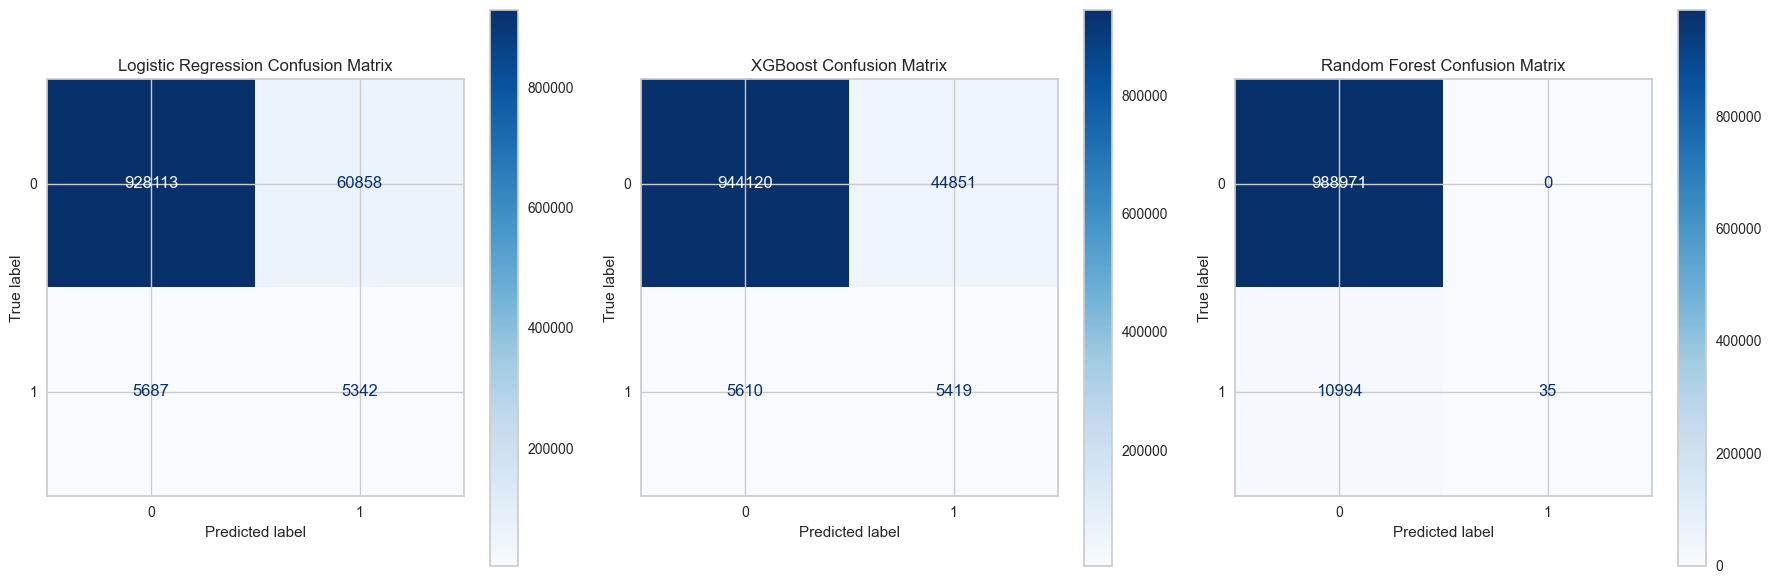

In [37]:
# Plot confusion matrices at 0.80 threshold
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

ConfusionMatrixDisplay(confusion_matrix=lr_cm, display_labels=[0, 1]).plot(ax=axes[0], cmap='Blues')
axes[0].title.set_text('Logistic Regression Confusion Matrix')

ConfusionMatrixDisplay(confusion_matrix=xgb_cm, display_labels=[0, 1]).plot(ax=axes[1], cmap='Blues')
axes[1].title.set_text('XGBoost Confusion Matrix')

ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=[0, 1]).plot(ax=axes[2], cmap='Blues')
axes[2].title.set_text('Random Forest Confusion Matrix')

plt.tight_layout()
plt.show()

In [38]:
# Function to calculate TPR and FPR
def calculate_tpr_fpr(confusion_matrix):
    tn, fp, fn, tp = confusion_matrix[0][0], confusion_matrix[0][1], confusion_matrix[1][0], confusion_matrix[1][1]
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    return tpr, fpr

# Calculate TPR and FPR for each model
tpr_lr, fpr_lr = calculate_tpr_fpr(lr_cm)
tpr_xgb, fpr_xgb = calculate_tpr_fpr(xgb_cm)
tpr_rf, fpr_rf = calculate_tpr_fpr(rf_cm)

print(f"Logistic Regression - TPR: {tpr_lr:.4f}, FPR: {fpr_lr:.4f}")
print(f"XGBoost - TPR: {tpr_xgb:.4f}, FPR: {fpr_xgb:.4f}")
print(f"Random Forest - TPR: {tpr_rf:.4f}, FPR: {fpr_rf:.4f}")

Logistic Regression - TPR: 0.4844, FPR: 0.0615
XGBoost - TPR: 0.4913, FPR: 0.0454
Random Forest - TPR: 0.0032, FPR: 0.0000


<a id="3.3"></a>
## <b><span style='color:yellow'>1st approach:</span></b> 

- Finding fraud accounts individually using each model.
- Taking the common accounts.

In [ ]:

df2['predicted_fraud'] = lr_predictions2 

# Identify fraudulent accounts (put the threshold)
fraudulent_accounts = df2[df2['predicted_fraud'] > 0.50]['Account_Number']

# Save fraudulent account numbers to a .txt file (overwrite mode)
with open('/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/archive/lr_fraudulent_accounts.txt', 'w') as file:
    fraudulent_accounts.to_csv(file, index=False, header=False)

# Print number and percentage of fraudulent accounts
num_fraud_accounts = len(fraudulent_accounts)
total_accounts = len(df2)
percentage_fraudulent = (num_fraud_accounts / total_accounts) * 100

print("Number of Fraudulent Accounts:", num_fraud_accounts)

print("Percentage of Fraudulent Accounts: {:.2f}%".format(percentage_fraudulent))


Number of Fraudulent Accounts: 72558
Percentage of Fraudulent Accounts: 14.51%


In [ ]:

df2['predicted_fraud'] = xgb_predictions2

# Identify fraudulent accounts (put the threshold)
fraudulent_accounts = df2[df2['predicted_fraud'] > 0.50]['Account_Number']

# Save fraudulent account numbers to a .txt file (overwrite mode)
with open('/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/archive/xgb_fraudulent_accounts.txt', 'w') as file:
    fraudulent_accounts.to_csv(file, index=False, header=False)

# Print number and percentage of fraudulent accounts
num_fraud_accounts = len(fraudulent_accounts)
total_accounts = len(df2)
percentage_fraudulent = (num_fraud_accounts / total_accounts) * 100

print("Number of Fraudulent Accounts:", num_fraud_accounts)
print("Percentage of Fraudulent Accounts: {:.2f}%".format(percentage_fraudulent))


In [ ]:

df2['predicted_fraud'] = rf_predictions

# Identify fraudulent accounts (put the threshold)
fraudulent_accounts = df2[df2['predicted_fraud'] > 0.50]['Account_Number']

# Save fraudulent account numbers to a .txt file (overwrite mode)
with open('/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/archive/rf_fraudulent_accounts.txt', 'w') as file:
    fraudulent_accounts.to_csv(file, index=False, header=False)

# Print number and percentage of fraudulent accounts
num_fraud_accounts = len(fraudulent_accounts)
total_accounts = len(df2)
percentage_fraudulent = (num_fraud_accounts / total_accounts) * 100

print("Number of Fraudulent Accounts:", num_fraud_accounts)
print("Percentage of Fraudulent Accounts: {:.2f}%".format(percentage_fraudulent))


In [ ]:

# Define file paths
lr_path = '/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/archive/lr_fraudulent_accounts.txt'
xgb_path = '/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/archive/xgb_fraudulent_accounts.txt'
rf_path = '/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/archive/rf_fraudulent_accounts.txt'
output_path = '/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/archive/fraudulent_accounts.txt'

# Read account numbers from each file
with open(lr_path, 'r') as lr_file:
    lr_accounts = set(lr_file.read().splitlines())

with open(xgb_path, 'r') as xgb_file:
    xgb_accounts = set(xgb_file.read().splitlines())

with open(rf_path, 'r') as rf_file:
    rf_accounts = set(rf_file.read().splitlines())

# Find common account numbers
common_accounts = lr_accounts & xgb_accounts & rf_accounts

# Write common account numbers to the output file
with open(output_path, 'w') as output_file:
    for account in common_accounts:
        output_file.write(account + '\n')

print(f"Number of common account numbers: {len(common_accounts)}")


Number of common account numbers: 145


<a id="3.3"></a>
## <b><span style='color:yellow'>2nd approach:</span></b> 

- Finding fraud accounts using the average of all models.

In [146]:
'''
# Average predictions
df2['predicted_fraud'] = (lr_predictions2 + xgb_predictions2 + rf_predictions2) / 3

# Identify fraudulent accounts (put the threshold)
fraudulent_accounts = df2[df2['predicted_fraud'] > 0.64]['Account_Number']

# Save fraudulent account numbers to a .txt file (overwrite mode)
with open('/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/archive/fraudulent_accounts.txt', 'w') as file:
    fraudulent_accounts.to_csv(file, index=False, header=False)

# Print number and percentage of fraudulent accounts
num_fraud_accounts = len(fraudulent_accounts)
total_accounts = len(df2)
percentage_fraudulent = (num_fraud_accounts / total_accounts) * 100

print("Number of Fraudulent Accounts:", num_fraud_accounts)

print("Percentage of Fraudulent Accounts: {:.2f}%".format(percentage_fraudulent))
'''

Number of Fraudulent Accounts: 99
Percentage of Fraudulent Accounts: 0.02%


<a id="3.3"></a>
## <b><span style='color:SteelBlue'>Loading the actual given fraudulent accounts</span></b> 

In [136]:
'''
# Actual Fraud Accounts

# Filter the rows where fraud_bool is 1
fraud_accounts = df2[df2['fraud_bool'] == 1]

# Get the unique account numbers with fraud_bool=1
unique_fraud_accounts = fraud_accounts['Account_Number'].unique()

# Define the output file path
output_file_path = '/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/archive/actual_fraudulent_accounts.txt'

# Save the unique account numbers to the text file
with open(output_file_path, 'w') as f:
    for account_number in unique_fraud_accounts:
        f.write(f"{account_number}\n")
'''

<a id="3.3"></a>
## <b><span style='color:SteelBlue'>Comparing my fraudulent accounts and actual fraudulent accounts.</span></b> 

In [153]:
# Percentage accuracy in the model

# File paths
file1_path = '/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/archive/fraudulent_accounts.txt'
file2_path = '/Users/gavesh_aggarwal/Desktop/Mule_Account_Detection/32 Column Dataset/archive/actual_fraudulent_accounts.txt'

# Load numbers from both files
with open(file1_path, 'r') as file1:
    numbers1 = set(map(int, file1.readlines()))

with open(file2_path, 'r') as file2:
    numbers2 = set(map(int, file2.readlines()))

# Find common numbers
common_numbers = numbers1.intersection(numbers2)

# Number of common numbers
num_common = len(common_numbers)

# Total numbers in fraudulent_accounts.txt
total_numbers_in_file1 = len(numbers1)

# Percentage of common numbers
percentage_common = (num_common / total_numbers_in_file1) * 100

print("Percentage of Correctly Identified Fraudulent Accounts: {:.2f}%".format(percentage_common))

Percentage of Correctly Identified Fraudulent Accounts: 9.66%
